In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

In [2]:
import sys
import os
sys.path.insert(0, os.path.abspath('../..'))

from UKMovementSensing import hsmm

import pandas as pd
import numpy as np

In [3]:
execfile('config.py')

## Load the data

In [4]:
filenames = os.listdir(train_path)
filenames = [fn for fn in filenames if os.path.isfile(os.path.join(train_path,fn))]
datasets = [pd.read_csv(os.path.join(train_path,fn)) for fn in filenames]
print(len(datasets))

414


In [5]:
for i in range(len(datasets)):
    datasets[i] = datasets[i].set_index('timestamp')
    datasets[i].index = pd.to_datetime(datasets[i].index) 

In [6]:
# Take one example datset and have a look
example_index = 2
example_data = datasets[example_index]

example_data.head()

,acceleration,EN,anglex,angley,anglez,roll_med_acc_x,roll_med_acc_y,roll_med_acc_z,dev_roll_med_acc_x,dev_roll_med_acc_y,dev_roll_med_acc_z,invalid,heuristic,filename,slot,activity,label,start_time,subset,switched_pos
timestamp,,,,,,,,,,,,,,,,,,,,
2015-02-24 04:00:00,0.002391,1.000538,-53.652273,-27.960324,-21.257091,-0.806737,-0.469618,-0.363140,0.001964,-0.000935,-0.00002,0,2,__022957_2015-03-11 12-31-53.bin_day2,1,1,Sleeping and resting (including sick in bed),2015-02-24 04:00:00+00:00,0,False
2015-02-24 04:00:05,0.002219,0.999820,-53.568500,-28.110847,-21.190274,-0.803126,-0.470334,-0.360819,-0.001012,-0.001233,-0.00044,0,2,__022957_2015-03-11 12-31-53.bin_day2,1,1,Sleeping and resting (including sick in bed),2015-02-24 04:00:00+00:00,0,False
2015-02-24 04:00:10,0.001664,0.999021,-53.571949,-28.079172,-21.224531,-0.802769,-0.469618,-0.361199,-0.000734,-0.001432,0.00006,0,2,__022957_2015-03-11 12-31-53.bin_day2,1,1,Sleeping and resting (including sick in bed),2015-02-24 04:00:00+00:00,0,False
2015-02-24 04:00:15,0.002355,1.000409,-53.475542,-28.141066,-21.284805,-0.802928,-0.471249,-0.362700,-0.001369,-0.000577,0.00050,0,2,__022957_2015-03-11 12-31-53.bin_day2,1,1,Sleeping and resting (including sick in bed),2015-02-24 04:00:00+00:00,0,False
2015-02-24 04:00:20,0.001695,0.999589,-53.521343,-28.054733,-21.326266,-0.802888,-0.469618,-0.363140,-0.001171,-0.000040,-0.00014,0,2,__022957_2015-03-11 12-31-53.bin_day2,1,1,Sleeping and resting (including sick in bed),2015-02-24 04:00:00+00:00,0,False


## Prepare data for HSMM

In [7]:
X_list = [d[column_names].as_matrix() for d in datasets]

## Train HSMM

/home/dafne/anaconda2/envs/ucl2/lib/python2.7/site-packages/pybasicbayes/util/stats.py:185: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  x = np.random.randn(nu,n)


0
Resampled 414 sequences in 1377.2 seconds
Log likelihood:  5672180.95709
Convergence: average Hamming distance is 0.582710226977
1
Resampled 414 sequences in 1293.2 seconds
Log likelihood:  10653199.0359
Convergence: average Hamming distance is 0.5476632405
2
Resampled 414 sequences in 1260.7 seconds
Log likelihood:  12418385.5798
Convergence: average Hamming distance is 0.334435805137
3
Resampled 414 sequences in 1230.6 seconds
Log likelihood:  13685195.5562
Convergence: average Hamming distance is 0.259931392191
4
Resampled 414 sequences in 1299.4 seconds
Log likelihood:  14754305.2653
Convergence: average Hamming distance is 0.191013748592
5
Resampled 414 sequences in 1246.7 seconds
Log likelihood:  15818675.8579
Convergence: average Hamming distance is 0.111588159491
6
Resampled 414 sequences in 1286.0 seconds
Log likelihood:  16585448.7982
Convergence: average Hamming distance is 0.0795584790381
7
Resampled 414 sequences in 1193.4 seconds
Log likelihood:  17319970.7475
Convergen

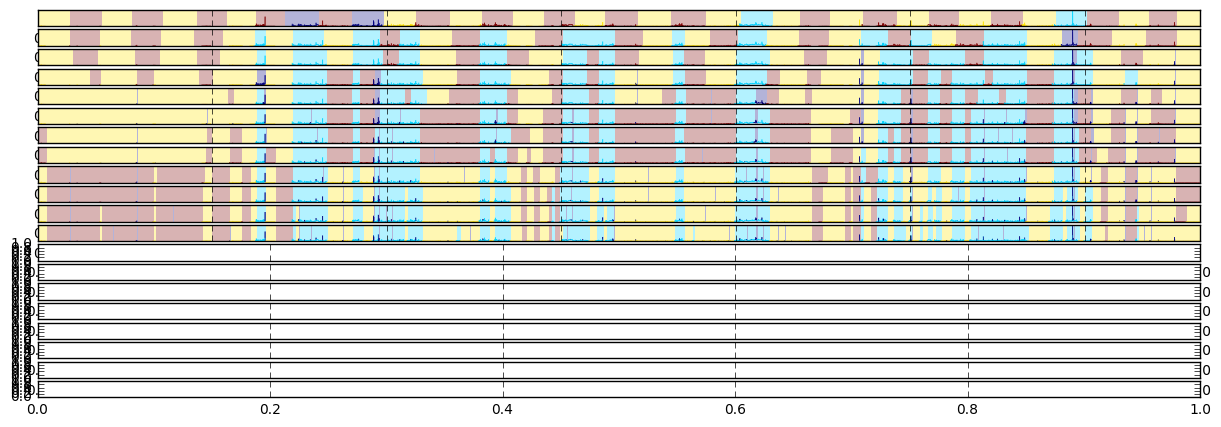

In [8]:
#Note that with many iterations, the visualization becomes badly visible
model, model_dist = hsmm.train_hsmm(X_list, Nmax=Nmax, nr_resamples=nr_resamples, trunc=truncate, visualize=True, example_index=example_index)

## Plot one example

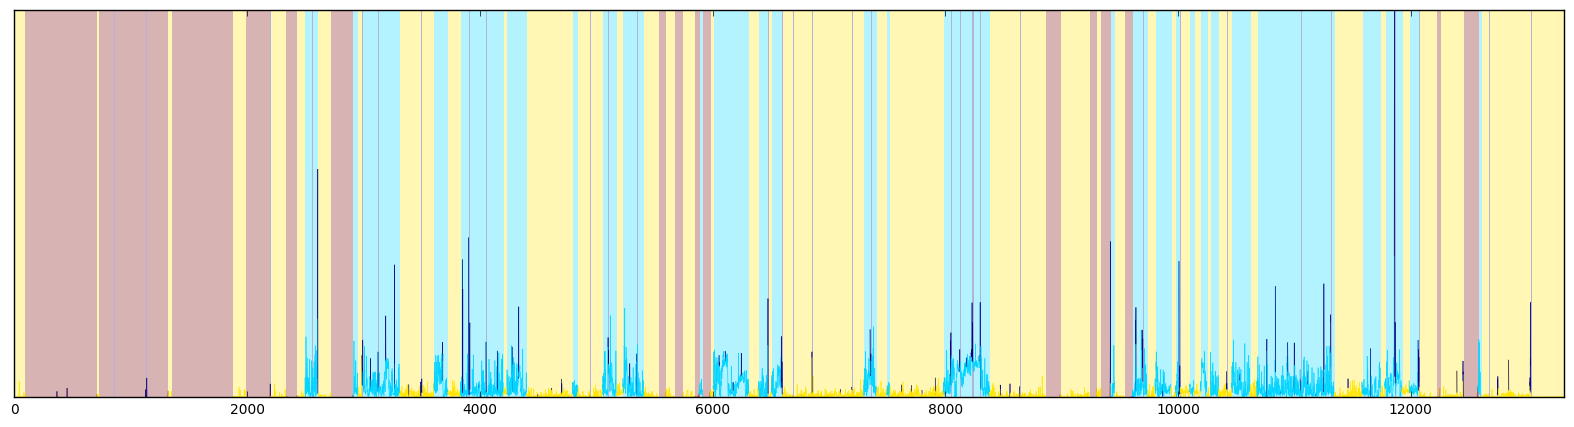

In [9]:
import matplotlib.pyplot as plt
plt.subplots(figsize=(20, 5))
model.plot_stateseq(example_index)

## Save the data with the states

Save the data including the states found. This labeled data serves as an input to the analyses.

In [10]:
if not os.path.exists(states_path_model):
        os.makedirs(states_path_model)
for i, dat in enumerate(datasets):
    dat['state'] = model.stateseqs[i]
    fn = str(str(dat['subset'][0]) + dat['filename'][0])+'.csv'
    dat.to_csv(os.path.join(states_path_model, fn))

## Save the model

NB: This removes the data from the model! Only run this if you've saved the data with states.

In [11]:
import pickle
#Remove the data from the model
model.states_list = []

if not os.path.exists(model_path):
        os.makedirs(model_path)
with open(os.path.join(model_path, model_name+'.pkl'), 'wb') as f:
    pickle.dump(model, file=f)

## Save the config

In [12]:
from shutil import copyfile

if not os.path.exists(config_path):
    os.makedirs(config_path)
copyfile('config.py', os.path.join(config_path, model_name+'_config.py'))

## Possibly: Apply the model to new data